# Gabor Filters for feature extraction in face recognition

In [1]:
from PIL import Image, ImageEnhance
import numpy as np
import pandas as pd
from PIL import ImageFilter
from matplotlib import pyplot as plt
import colorsys
import cv2
import os
from skimage.filters import gabor, gaussian
from IPython.display import display 
from matplotlib.pyplot import imshow
from pywt import dwt2
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.cluster import KMeans
import random

%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
rootLFW="/kaggle/input/lfw-augmented/Augmented_LFW_final/Augmented_LFW_Final/"
rootCD ="/kaggle/input/custom-dataset/Custom_Dataset/"

In [194]:
print(sum([len(os.listdir(rootLFW + x)) for x in os.listdir(rootLFW)]),'images,',
     len(os.listdir(rootLFW)),'people','(LFW)')
print(sum([len(os.listdir(rootCD + x)) for x in os.listdir(rootCD)]),'images,',
     len(os.listdir(rootCD)),'people','(CD)')

3408 images, 50 people (LFW)
2816 images, 39 people (CD)


## Some images from the dataset

(250, 250)


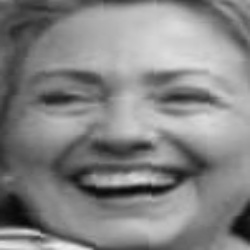

In [104]:
file = "Hillary_Clinton/1.jpg"
image = Image.open(root+file).convert('L')
image_size = image.size
print(image_size)
display(image)

LFW


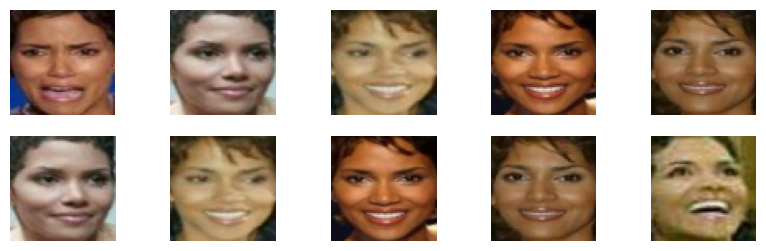

In [196]:
print('LFW')
fig, ax = plt.subplots(2,5,figsize=(10,3))
for i in range(2):
    for j in range(5):
        im = cv2.cvtColor(cv2.imread(rootLFW+f'Halle_Berry/{8*i+8*j+1}.jpg'),
                                                         cv2.COLOR_BGR2RGB)
        ax[i,j].imshow(cv2.resize(im,(64,64)))
        ax[i,j].axis('off')
fig.show()

CD


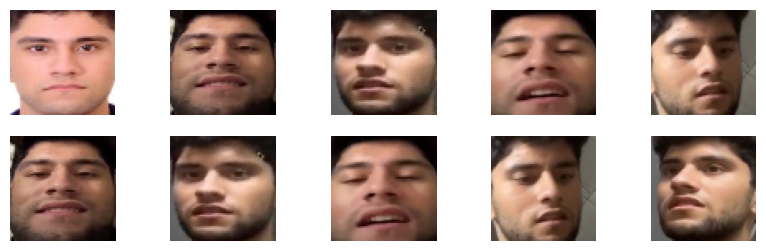

In [252]:
print('CD')
fig, ax = plt.subplots(2,5,figsize=(10,3))
for i in range(2):
    for j in range(5):
        im = cv2.cvtColor(cv2.imread(rootCD+f'naman/{8*i+8*j+1}.jpg'),
                                                         cv2.COLOR_BGR2RGB)
        ax[i,j].imshow(cv2.resize(im,(64,64)))
        ax[i,j].axis('off')
fig.show()

## Preprocessing - brightness adjustment

In [114]:
def enhance_brightness(image):
    mean_brightness = get_brightness(image)
    a, b = [0.3, 1]
    if mean_brightness<0.1:
        a = 0.1
    min_, max_ = [0, 1]
    new_brightness = (b - a) * (mean_brightness - min_) / (max_ - min_) + a
    brightness_factor = new_brightness/mean_brightness
    enhancer = ImageEnhance.Brightness(image)
    enhanced_image = enhancer.enhance(brightness_factor).convert('L')
    return np.array(enhanced_image.getdata(),
                    dtype=np.uint8).reshape((250,250))

def get_brightness(image):
    brightness = []
    pixel_values = list(image.getdata())
    for values in pixel_values:
        R, G, B = values
        bright = np.sqrt(0.299 * R ** 2 + 0.587 * G ** 2 + 0.114 * B ** 2)/255
        brightness.append(bright)
    return np.mean(brightness)

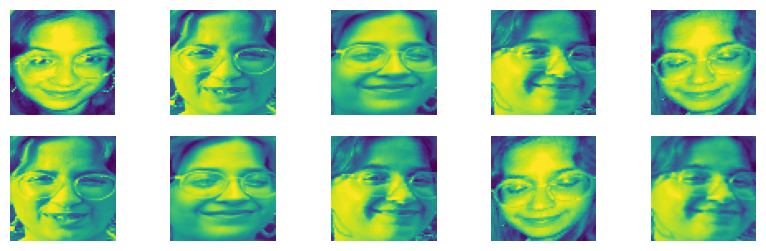

In [201]:
fig, ax = plt.subplots(2,5,figsize=(10,3))
for i in range(2):
    for j in range(5):
        im = Image.open(rootCD+f'pavani/{8*i+8*j+1}.jpg').convert('RGB')
        converter = ImageEnhance.Color(im)
        im = converter.enhance(0.5)
        im = enhance_brightness(im)
        ax[i,j].imshow(cv2.resize(im,(64,64)))
        ax[i,j].axis('off')
fig.show()

## Visualising gabor filters

In [6]:
def create_gabor_filter_bank(ksize, sigma, theta, lambd, gamma):
    filters = []
    for t in theta:
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, 
                                    np.deg2rad(t), lambd, gamma, 0, 
                                    ktype=cv2.CV_32F)
        filters.append(kernel)
    return filters

In [7]:
ksize = 9                       # Size of the filter
sigma = 2.0                     # Standard deviation of the Gaussian envelope
theta = [0,30,60,90,120,150]    # Orientation of the Gabor filter
lambd = 5.0                     # Wavelength of the sinusoidal factor
gamma = 0.5                     # Spatial aspect ratio

filter_bank = create_gabor_filter_bank(ksize, sigma, theta, lambd, gamma)
np.array(filter_bank).shape

(6, 9, 9)

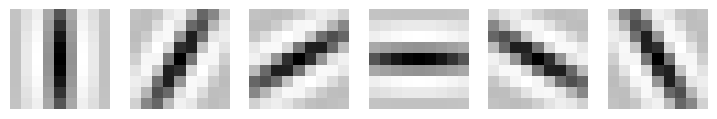

In [40]:
fig, ax = plt.subplots(1,6,figsize=(9,54))
for i in range(6):
    ax[i].imshow(filter_bank[i],cmap='Greys')
    ax[i].axis('off')
fig.show()

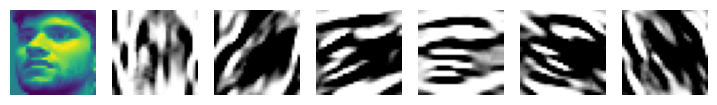

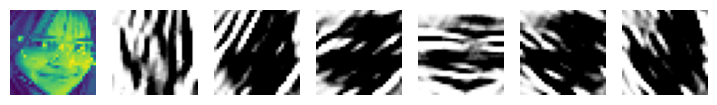

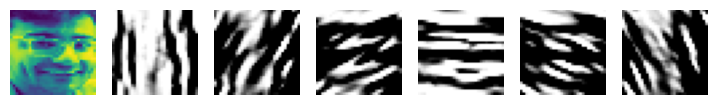

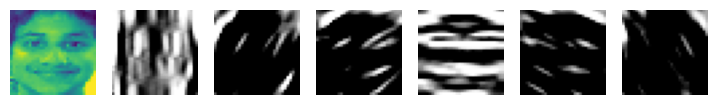

In [38]:
for name in ['naman/45.jpg','disha/14.jpg','harsh/12.jpg','rishabh/7.jpg']:
    fig, ax = plt.subplots(1,7,figsize=(9,63))
    im = cv2.resize(cv2.imread(rootCD+name,cv2.IMREAD_GRAYSCALE),
                    (32,32))
    ax[0].imshow(im)
    ax[0].axis('off')
    for i in range(1,7):
        ax[i].imshow(cv2.filter2D(im, cv2.CV_8UC3,filter_bank[i-1]),
                     cmap='Greys')
        ax[i].axis('off')
    fig.show()

In [119]:
def apply_gabor_filters(image, filters):
    responses = []
    for kernel in filters:
        filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
        responses.append(filtered_image)
    return responses

def extract_features(image, filter_bank):
    responses = apply_gabor_filters(image, filter_bank)
    features = np.concatenate(responses, axis=1)  
    return features.flatten()

# Results

In [143]:
def apply_pca(data,n):
    standardized_data = StandardScaler().fit_transform(data)
    pca = PCA(n_components=n)
    pca.fit(standardized_data)
    transformed_data = pca.transform(standardized_data)
    return transformed_data

### 1. LFW dataset

In [236]:
X = []
Y = []
images = []
for person in os.listdir(rootLFW):
    for file in os.listdir(rootLFW+person):
        path = root + person + '/' + file
        im = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(32,32))
        X.append(extract_features(im,filter_bank))
        images.append(im)
        Y.append(person.replace('_',' '))
X = np.array(X)
Y = np.array(Y)

In [237]:
X.shape

(3408, 6144)

#### Model training

In [238]:
X = apply_pca(X,2048)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                          random_state=42)

In [239]:
k = 5                                                 # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, Y_train)
Y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='macro')
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9178885630498533
F1 Score: 0.9183512457609683
Precision: 0.9290675986313727
Recall: 0.9177521615559576


#### Some failed predictions :

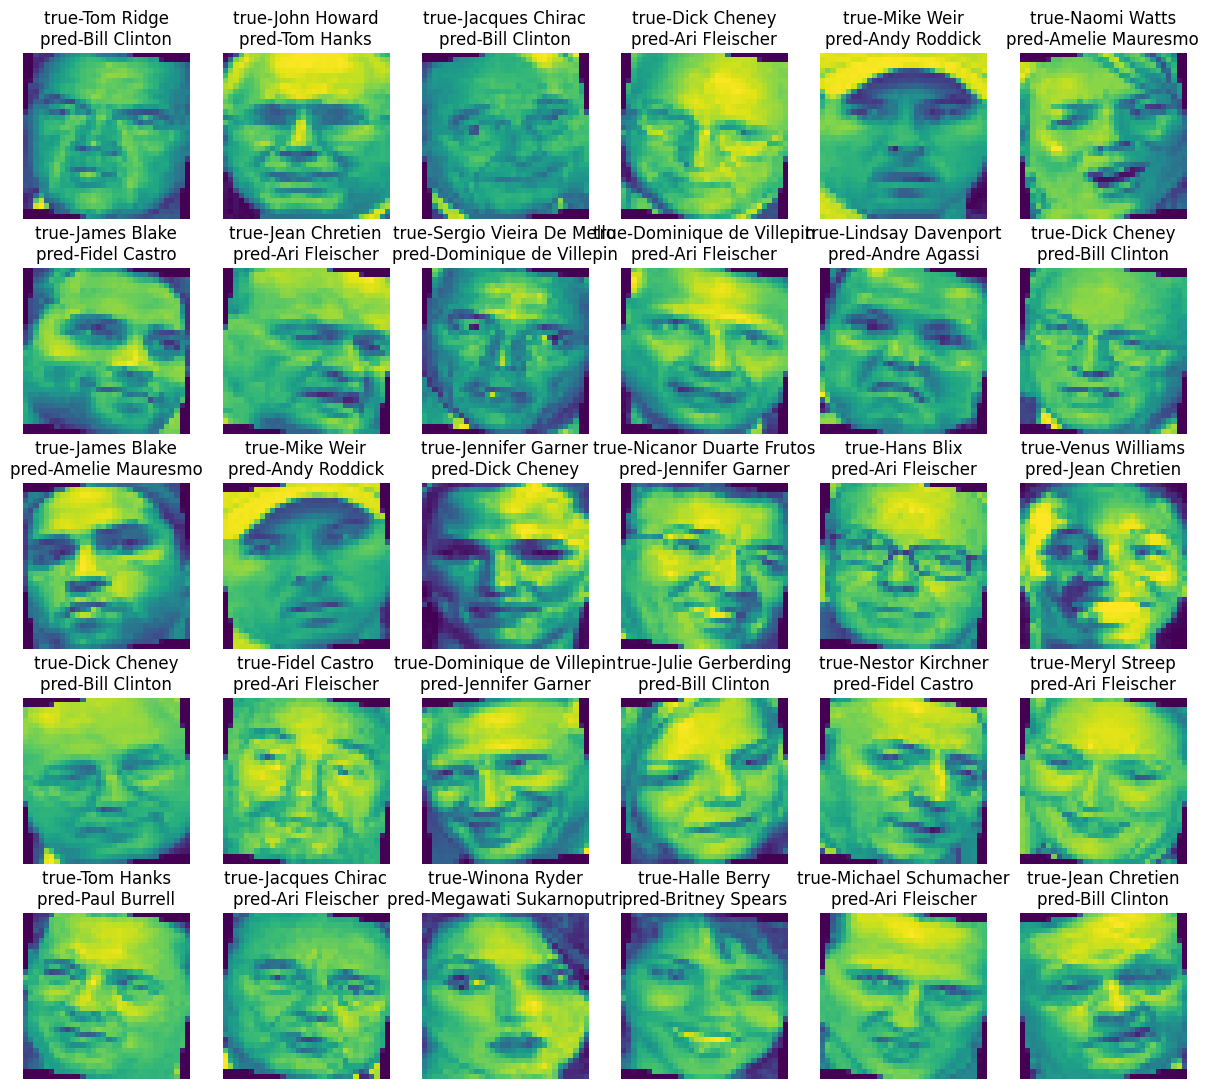

In [240]:
l = []
n = 0
fig, ax = plt.subplots(5,6,figsize=(15,13.5))
while(len(l)<30):
    x = random.randint(0, 3407)
    true,pred = Y[x],knn_classifier.predict([X[x]])[0]
    if x in l or true == pred:
        continue
    l.append(x)
    n = len(l)-1
    ax[n//6,n%6].imshow(images[x])
    ax[n//6,n%6].set_title(f'true-{true}\npred-{pred}')
    ax[n//6,n%6].axis('off')

#### Visualising clusters in the dataset

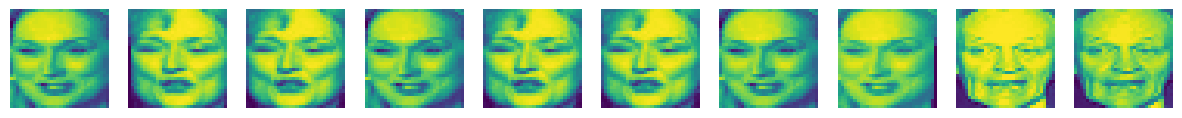

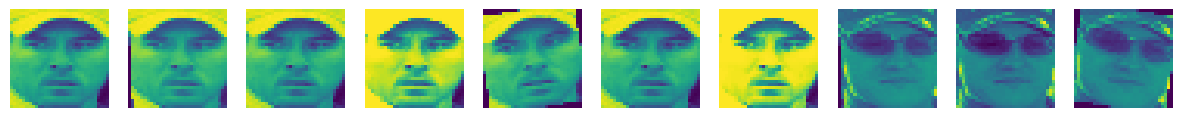

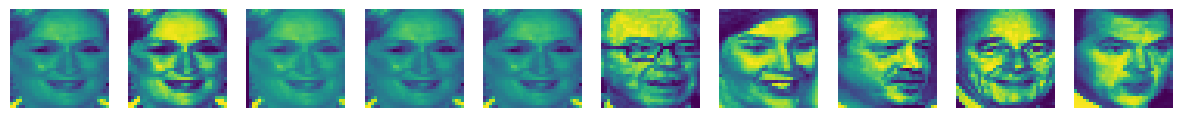

In [242]:
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

unique_clusters = np.unique(labels)
selected_clusters = random.sample(list(unique_clusters), 3)

for i, cluster_id in enumerate(selected_clusters, 1):
    cluster = np.array(images,dtype=np.uint8)[labels == cluster_id]
    fig,ax = plt.subplots(1,10,figsize=(15,60))
    for i in range(10):
        if i>=len(cluster):
            break
        ax[i].imshow(cluster[i])
        ax[i].axis('off')
    fig.show()

### 2. Custom dataset

In [248]:
X = []
Y = []
images = []
for person in os.listdir(rootCD):
    for file in os.listdir(rootCD+person):
        path = rootCD + person + '/' + file
        im = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(32,32))
        X.append(extract_features(im,filter_bank))
        images.append(im)
        Y.append(person.replace('_',' '))
X = np.array(X)
Y = np.array(Y)

In [249]:
X.shape

(2816, 6144)

#### Model training

In [250]:
X = apply_pca(X,2048)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                          random_state=42)

In [251]:
k = 5                                                 # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, Y_train)
Y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='macro')
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9573964497041421
F1 Score: 0.9597078830648528
Precision: 0.9648110630642014
Recall: 0.9586250500341776


#### Some failed predictions :

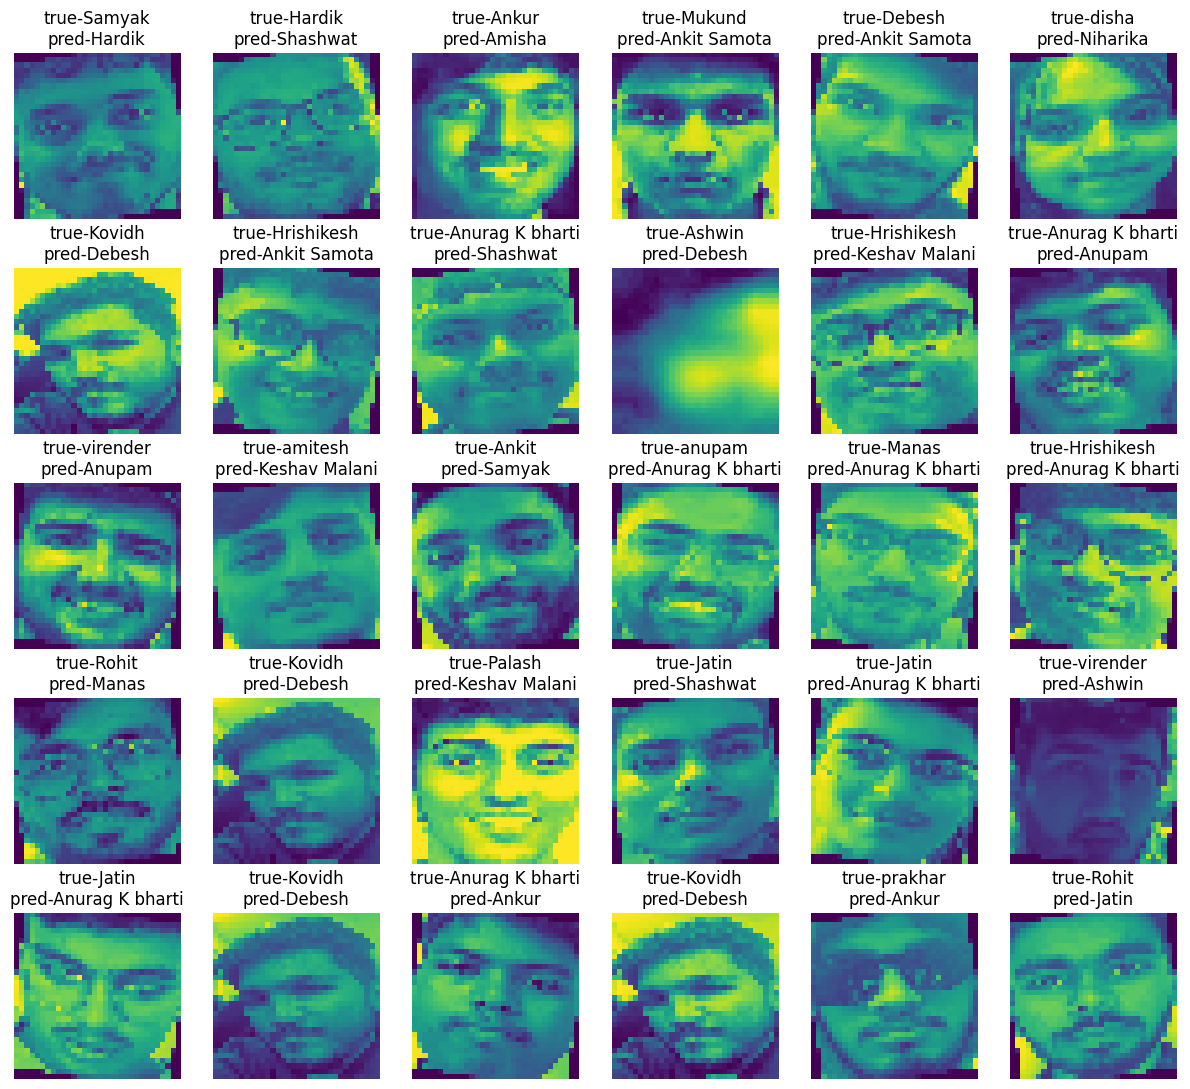

In [233]:
import random
l = []
n = 0
fig, ax = plt.subplots(5,6,figsize=(15,13.5))
while(len(l)<30):
    x = random.randint(0, 2815)
    true,pred = Y[x],knn_classifier.predict([X[x]])[0]
    if x in l or true == pred:
        continue
    l.append(x)
    n = len(l)-1
    ax[n//6,n%6].imshow(images[x])
    ax[n//6,n%6].set_title(f'true-{true}\npred-{pred}')
    ax[n//6,n%6].axis('off')

#### Visualising clusters in the dataset

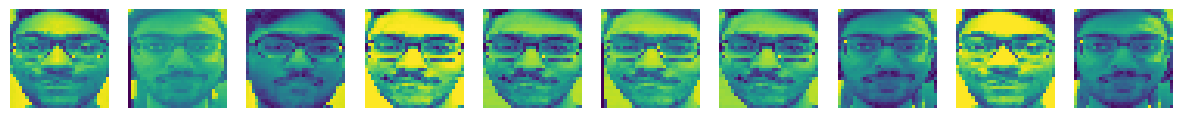

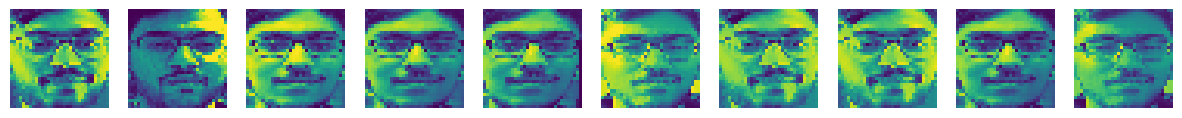

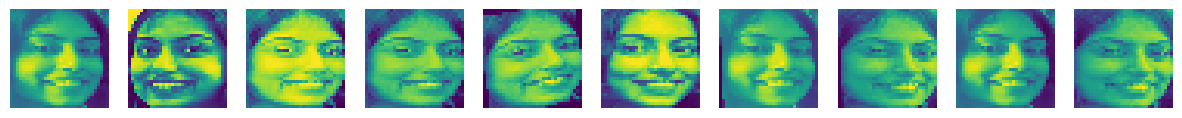

In [209]:
kmeans = KMeans(n_clusters=39, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

unique_clusters = np.unique(labels)
selected_clusters = random.sample(list(unique_clusters), 3)

for i, cluster_id in enumerate(selected_clusters, 1):
    cluster = np.array(images,dtype=np.uint8)[labels == cluster_id]
    fig,ax = plt.subplots(1,10,figsize=(15,60))
    for i in range(10):
        if i>=len(cluster):
            break
        ax[i].imshow(cluster[i])
        ax[i].axis('off')
    fig.show()